# Introduction 02_FPHDP_KNNImputation_LR


01-FPHDP used logistic regression, because it was used in Sci-kit Learns ColumnTransformer example. (Fortunately logisitc regression is useful for classification.) In 02_FPHDP_KNNImputation_LR we replace SimpleImputer with KNNImputer and forgo the data evaluation phase, the groundwork for which was already made in 01-FPHDP (Final Project Heart Disease Prediction)





### Import Libraries

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving heart.csv to heart.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, roc_auc_score, auc
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV


np.random.seed(42)

In [ ]:
#Pandas dataframe
heart = pd.read_csv("/content/heart.csv")

In [ ]:
#https://www.youtube.com/watch?v=JR92LxKgMBE
numeric_features = heart.select_dtypes(include=[np.number])
numeric_features.columns

Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak',
       'HeartDisease'],
      dtype='object')

In [ ]:
categorical_features = heart.select_dtypes(include=[object])
categorical_features.columns

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

In [ ]:
#X = heart.loc[:, :'ST_Slope']
X= heart.drop('HeartDisease', axis=1)
#y = heart.HeartDisease
y = heart['HeartDisease']

In [ ]:
X.shape


(918, 11)

In [ ]:
y.shape

(918,)

In [ ]:
# Verifying X has the features I expect
X.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

In [ ]:
numeric_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
numeric_transformer = Pipeline(
    steps=[("imputer", KNNImputer(missing_values=0, n_neighbors=5)), ("scaler", StandardScaler())]
)

categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
)

#https://www.youtube.com/watch?v=qmqCYC-MBQo by Siddhardhan: idea to
# startify y so that we have a balanced response values within test set and
# training set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)

clf.fit(X_train, y_train)

#https://www.youtube.com/watch?v=qmqCYC-MBQo by Siddhardhan: looking at accuracy score
X_train_prediction = clf.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, y_train)
print("Accuracy on training data :", training_data_accuracy)


print("model score on test set: %.3f" % clf.score(X_test, y_test))

Accuracy on training data : 0.8474114441416893
model score on test set: 0.864


Since the accuracy scores on the training data and the test set are relatively close I am not concerned about overfitting, especially since the test set accuracy is higher than that of the training set.

'Grid search can also be performed on the different preprocessing steps defined in the ColumnTransformer object, together with the classifier's hyperparameters as part of the Pipeline. We will search for both the imputer strategy of the numeric preprocessing and the regularization parameter of the logistic regression using :class:~sklearn.model_selection.GridSearchCV.'

In [ ]:
param_grid = {
    "preprocessor__num__imputer__n_neighbors": [2,3,5,10],
    "classifier__C": [0.1, 1.0, 10, 100],
}


grid_search = GridSearchCV(clf, param_grid, cv=10)
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer(missing_values=0)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'RestingBP',
                                                                          'Cholesterol',
                                                                          'FastingBS',
                                                                   

In [ ]:
grid_search.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__imputer', 'preprocessor__num__scaler', 'preprocessor__num__imputer__add_indicator', 'preprocessor__num__imputer__copy', 'preprocessor__num__imputer__metric', 'preprocessor__num__imputer__missing_values', 'preprocessor__num__imputer__n_neighbors', 'preprocessor__num__imputer__weights', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__categories', 'preprocessor__cat__drop', 'preprocessor__cat__dtype', 'preprocessor__cat__handle_unknown', 'preprocessor__cat__sparse', 'class

In [ ]:
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Best params:
{'classifier__C': 0.1, 'preprocessor__num__imputer__n_neighbors': 2}


'The internal cross-validation scores obtained by those parameters is:'

In [ ]:
print(f"Internal CV score: {grid_search.best_score_:.3f}")

Internal CV score: 0.847


'We can also introspect the top grid search results as a pandas dataframe:'

In [ ]:
import pandas as pd

cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results.head(8)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_preprocessor__num__imputer__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.115887,0.028611,0.031354,0.009435,0.1,2,"{'classifier__C': 0.1, 'preprocessor__num__imp...",0.878378,0.891892,0.837838,0.864865,0.876712,0.794521,0.835616,0.835616,0.821918,0.835616,0.847297,0.028385,1
8,0.140540,0.035370,0.027832,0.008674,10,2,"{'classifier__C': 10, 'preprocessor__num__impu...",0.891892,0.891892,0.837838,0.878378,0.876712,0.808219,0.849315,0.835616,0.808219,0.780822,0.845890,0.036731,2
12,0.136978,0.020596,0.039696,0.011353,100,2,"{'classifier__C': 100, 'preprocessor__num__imp...",0.891892,0.891892,0.837838,0.878378,0.876712,0.808219,0.849315,0.835616,0.808219,0.780822,0.845890,0.036731,2
1,0.105160,0.026924,0.029775,0.014344,0.1,3,"{'classifier__C': 0.1, 'preprocessor__num__imp...",0.878378,0.878378,0.837838,0.864865,0.876712,0.794521,0.835616,0.835616,0.808219,0.808219,0.841836,0.030016,4
5,0.164015,0.051478,0.031587,0.010982,1.0,3,"{'classifier__C': 1.0, 'preprocessor__num__imp...",0.878378,0.878378,0.837838,0.878378,0.876712,0.794521,0.849315,0.835616,0.808219,0.780822,0.841818,0.035248,5
9,0.137727,0.043029,0.040979,0.021285,10,3,"{'classifier__C': 10, 'preprocessor__num__impu...",0.878378,0.878378,0.837838,0.878378,0.876712,0.794521,0.849315,0.835616,0.808219,0.780822,0.841818,0.035248,5
13,0.123331,0.009829,0.029062,0.007314,100,3,"{'classifier__C': 100, 'preprocessor__num__imp...",0.878378,0.878378,0.837838,0.878378,0.876712,0.794521,0.849315,0.835616,0.808219,0.780822,0.841818,0.035248,5
4,0.114756,0.022551,0.027066,0.008410,1.0,2,"{'classifier__C': 1.0, 'preprocessor__num__imp...",0.878378,0.891892,0.837838,0.878378,0.876712,0.808219,0.835616,0.821918,0.808219,0.780822,0.841799,0.035815,8


'The best hyper-parameters have been used to re-fit a final model on the full training set. We can evaluate that final model on held out test data that was not used for hyperparameter tuning.'

In [ ]:
print(
    (
        "best logistic regression from grid search: %.3f"
        % grid_search.score(X_test, y_test)
    )
)

best logistic regression from grid search: 0.864


**https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py**

Above code and text can be found in the link to the Column Transformer example in Sci-Kit Learn.

In [ ]:
heartdisease_y_pred = clf.predict(X_test)
heartdisease_y_pred

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1])

The GridSearchCV object itself doesn't have a coefficient, because it's not an estimator, it's an object that cycles through parameters and trains various estimators.
https://stackoverflow.com/questions/62776587/python-gridsearchcv-object-has-no-attribute-coef

In [ ]:
y_test.shape



(184,)

In [ ]:
heartdisease_y_pred.shape

(184,)

In [ ]:
# Both arguments require the same number of samples
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, heartdisease_y_pred)

array([[71, 11],
       [14, 88]])

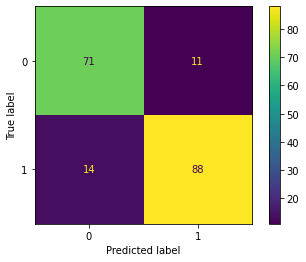

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, heartdisease_y_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

#TN | FP
#FN | TP

#Even though the L-to-R diagonal is high valued, is it acceptable to have 7
#false negatives when it means failure to diagnose a real case of heart disease?

In [ ]:
accuracy_score(y_test, heartdisease_y_pred) # Classification accuracy = (TP + TN)/(TP + TN + FP + FN)

0.8641304347826086

In [ ]:
1-accuracy_score(y_test, heartdisease_y_pred) #Classification error = (FP + FN)/(TP + TN + FP + FN)

0.13586956521739135

Specificity: when the actual value is negative how often is the prediction correct?   TN/(TN+FP)  
71/(71+11) = 0.865854

False Positive Rate: when the actual value is negative, how often is the prediction incorrect? FP/(TN+FP) = 11/(71+11) = 0.134146

(1 - Specificity)

In [ ]:
#Precision when a positive value is predicted, how often is the prediciton correct? TP/TP + FP
precision_score(y_test, heartdisease_y_pred)

0.8888888888888888

The roc curve requires either the probabilities or the non-thresholded decision values from the estimator. Since the logistic regression provides a decision function, we will use it to plot the roc curve:
https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_display_object_visualization.html#sphx-glr-auto-examples-miscellaneous-plot-display-object-visualization-py

**RocCurveDisplay**

0.9246771879483501


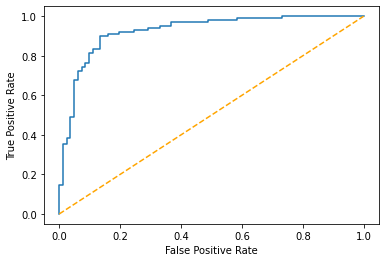

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
y_score = clf.decision_function(X_test)
import matplotlib.pyplot as plt


fpr, tpr, _ = roc_curve(y_test, y_score, pos_label = clf.classes_[1])
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.plot([0, 1], [0, 1], color="orange", linestyle="--")
print(roc_auc)

ROC curves typically feature TPR (Sensitivity; recall; probability of detection) on the Y axis, and FPR (1-Specificity; the probability of false alarm) on the X axis, for all possible classificaton thresholds ranging from 0 to 1. ROC curve visualizes all possible classification thresholds. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. “Steepness” of ROC curves is also important, since it is ideal to maximize the TPR while minimizing the FPR.

True Positive Rate = true positives / all positives
When the actual classification is positive (Heart Disease in this case), how often does the classifier predict positive? Range [0, 1]

False Positive Rate = false positives / all negatives
When the actual classification is negative (no Heart Disease in this case), how often does the classifier incorrectly predict positive? Range [0, 1]

ROC curves are useful even if your predicted probabilities are not properly calibrated from 0 to 1. What matters is how well the classifier separated the two classes. AUC represents the probability that a classifier will rank a randomly choesn positive observation higher than a randomly chosen negative observation; AUC is a useful metric even when classes are highly unbalanced.

Choosing a classification threshold depends on whether you want to minimize FPR or maximize TPR. A low threshhold may result in a lot of False Positives but may be considered desireable if the goal is to collect all true positives and minimize a case where a real instance is misclassified. The ROC curve will help you understand the impact of your choice of threshhold.

Here is a link to understan the ROC curve, pointed out by Data School:
http://www.navan.name/roc/


In [ ]:
roc_auc_score(y_test, heartdisease_y_pred)

0.8642993782879005

**PrecisionRecallDisplay**

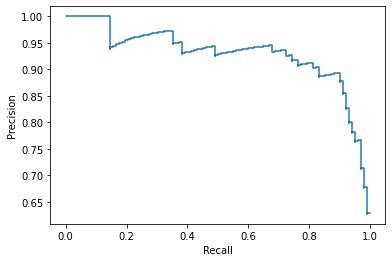

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, **precision** is a measure of result relevancy (**out of all predictions**, how many were correctly classified for the given class; TP/(TP+FP), while **recall** (truth as baseline; **out of all actual positives for the given class**, how many were correctly classified; TP/(TP+FN)) is a measure of how many truly relevant results are returned.
The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.



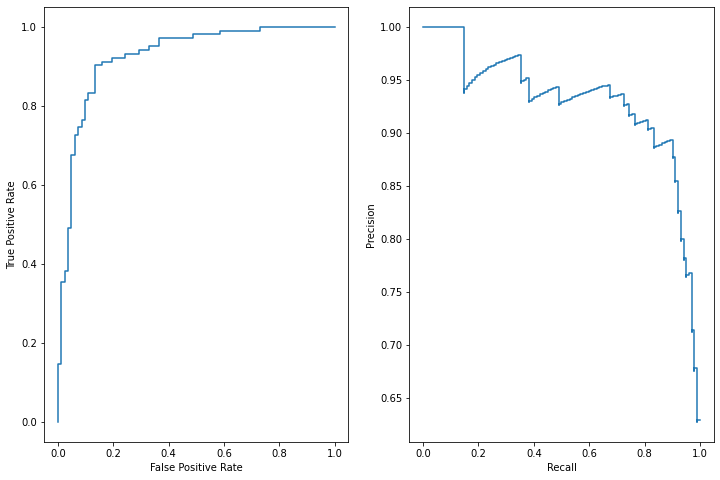

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

**Build a predictive system, courtesy https://www.youtube.com/watch?v=qmqCYC-MBQo by Siddhardhan** and https://machinelearningmastery.com/how-to-connect-model-input-data-with-predictions-for-machine-learning/

In [ ]:
#array
cols = ['Age', 'Sex','ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak' , 'ST_Slope']

# copy/paste just instance values into first array; include parentheses around string
df = pd.DataFrame([[44,'M','ASY',150,412,0,'Normal',170,'N',0,'Up']], columns = cols)
prediction = clf.predict(df)

print(prediction)

if prediction[0]==0 :
  print('This patient does not have heart disease')
else:
  print('This patient has heart disease')



[0]
This patient does not have heart disease


Both KNNImputer and IterativeImputer take a multivariate (multi feature) approach, taking into account correlations between features.

https://www.youtube.com/watch?v=NGq8wnH5VSo ColumnTransfrom different processing on selective columns

https://www.youtube.com/watch?v=m_qKhnaYZlc  Cannot use categorical variable as direct input for either of these.



https://www.youtube.com/watch?v=6as06vtXNL8   fit_transform vs transform

https://www.youtube.com/watch?v=yv4adDGcFE8 reason to preprocess in sci-kit learn

https://www.youtube.com/watch?v=1Y6O9nCo0-I  make pipeline

https://www.youtube.com/watch?v=jzKSAeJpC6s tranformer vs estimator and use in pipeline



https://scikit-learn.org/stable/search.html?q=knn+imputer

https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html?highlight=knn%20imputer

https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html?highlight=knn%20imputer

import numpy as np
from sklearn.impute import KNNImputer

X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]

imputer = KNNImputer(n_neighbors=2)

imputer.fit_transform(X)


https://www.kaggle.com/code/ashishkumarpanda/heart-failure-prediction-beginner-s-approach-to-ml

Rrnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

Chapter 7